# Picture and Art blender( neural style transfer) 


In [62]:
# import libaries 
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image
import numpy as np
import tensorflow as tf
from tensorflow.python.framework.ops import EagerTensor
#import pprint

### define the name names and paths of the content image and style image. 

In [84]:
content_image = "golden_state_bridge.jpeg"
style_image = "the_truth_of_nature.jpeg"
content_image_path = f"image/pictures/{content_image}"
style_image_path = f"image/arts/{style_image}"
image_size = 400

### to make the model train faster, I used weights from a VGG19 network architucture model that have been trained on imagenet dataset 

In [85]:
#create a function to resize the content image as well as the style image.(default input image size should be 400x400)
def image_resize(image_path,image_size=image_size):
    image = np.array(Image.open(image_path).resize((image_size,image_size)))
    image = tf.constant(np.reshape(image, ((1,) + image.shape)))
    image = image[:, :, :,:3]
    return image

In [86]:
tf.random.set_seed(2) 
vgg = tf.keras.applications.VGG19(include_top=False,
                                  input_shape=(image_size, image_size, 3),
                                  weights='imagenet')

vgg.trainable = False

In [87]:
#display the layers in the vgg19 architecture
for layer in vgg.layers:
    print(layer.name)

input_3
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


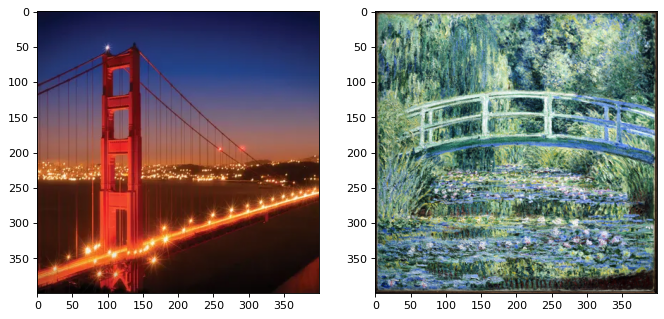

In [88]:
#display the content image and style image
content_image = image_resize(content_image_path,image_size)
style_image = image_resize(style_image_path,image_size)
plt.figure(figsize=(10, 10), dpi=80)
plt.subplot(1, 2, 1)
imshow(content_image[0])

plt.subplot(1, 2, 2)
imshow(style_image[0])

## for this part, we need to compute the cost function. 

### the cost function is composed of two different elements: content cost and style cost. it can be written as:$J(G) = \alpha J_{content}(C,G) + \beta J_{style}(S,G)$. where J_content is content cost and J_style is style cost 

#### three steps should be taken to compute the cost of the total cost 

1.compute the content cost 
2.compute the style cost 
3.combine them together. we should get the total cost 

to compute the content cost we need to the content output and the generated output. our goal is to make content output as similar to generated output as possible. it should follow the equation:$$J_{content}(C,G) =  \frac{1}{4 \times n_H \times n_W \times n_C}\sum _{ \text{all entries}} (a^{(C)} - a^{(G)})^2 $$

In [89]:

def compute_content_cost(content_output, generated_output):
    """
    Computes the content cost
    
    Arguments:
    a_C -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing content of the image C 
    a_G -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing content of the image G
    
    Returns: 
    J_content -- content cost 
    """
    a_C = content_output[-1]
    a_G = generated_output[-1]
    
    # Retrieve dimensions from a_G
    _, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    # Reshape a_C and a_G
    a_C_unrolled = tf.transpose(tf.reshape(a_C,shape=[-1,n_C]))
    a_G_unrolled = tf.transpose(tf.reshape(a_G,shape=[-1,n_C]))
    
    # compute the cost with tensorflow 
    J_content = (1/(4*n_H*n_W*n_C))*tf.reduce_sum(tf.square(tf.subtract(a_C_unrolled,a_G_unrolled)))
    
    return J_content

to compute style cost of a single layer [L] we need to compute the following cost function 
$$J_{style}^{[l]}(S,G) = \frac{1}{4 \times {n_C}^2 \times (n_H \times n_W)^2} \sum _{i=1}^{n_C}\sum_{j=1}^{n_C}(G^{(S)}_{(gram)i,j} - G^{(G)}_{(gram)i,j})^2 $$


* G and S corresponding to activations representing generated image and style image.
* $G_{gram}^{(S)}$ Gram matrix of the "style" image.
* $G_{gram}^{(G)}$ Gram matrix of the "generated" image.


in order to find the correlation of different channels/filters. we used gram matrix, it is basically a covariance matrix for each pair of channels this is important for computing style cost 

In [90]:

#inplement gram matrix
def gram_matrix(A):
    """
    Argument:
    A -- matrix of shape (n_C, n_H*n_W)
    
    Returns:
    GA -- Gram matrix of A, of shape (n_C, n_C)
    """ 
    GA = tf.linalg.matmul(A,tf.transpose(A))
    
    return GA

now we have the gram matrix, the intuition of the single layer style cost is to determine if the correlation between each channels from hidden layer activations representing style of the image S is similar to that of the image G.  if they are similar then the cost will be small, otherwise the cost will be large

In [91]:
# compute_layer_style_cost

def compute_layer_style_cost(a_S, a_G):
    """
    Arguments:
    a_S -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing style of the image S 
    a_G -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing style of the image G
    
    Returns: 
    J_style_layer -- tensor representing a scalar value, style cost defined above by equation (2)
    """
    
    # Retrieve dimensions from a_G (≈1 line)
    _, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    # Reshape the images from (n_H * n_W, n_C) to have them of shape (n_C, n_H * n_W) (≈2 lines)
    a_S = tf.transpose(tf.reshape(a_S,shape = [n_H*n_W,n_C]))
    a_G = tf.transpose(tf.reshape(a_G,shape = [n_H*n_W,n_C]))

    # Computing gram_matrices for both images S and G (≈2 lines)
    GS = gram_matrix(a_S)
    GG =  gram_matrix(a_G)

    # Computing the loss (≈1 line)
    J_style_layer = (1/(4*(n_C**2)*(n_H*n_W)**2))*tf.reduce_sum(tf.square(tf.subtract(GS,GG)))
    
    return J_style_layer

the content and style of images can be represented using intermediate layers and the style cost for each layers  $\lambda^{[l]}$  has been assigned. since we used five layers to represent the style of our image, each layer get weighted equally. 

In [92]:
style_layers = [
    ('block1_conv1', 0.2),
    ('block2_conv1', 0.2),
    ('block3_conv1', 0.2),
    ('block4_conv1', 0.2),
    ('block5_conv1', 0.2)]

content_layer = [('block5_conv4', 1)]

In [93]:
vgg.get_layer('block5_conv4').output

<KerasTensor: shape=(None, 25, 25, 512) dtype=float32 (created by layer 'block5_conv4')>

we now can combine the style costs for different layers as follows:

$$J_{style}(S,G) = \sum_{l} \lambda^{[l]} J^{[l]}_{style}(S,G)$$

where the values for $\lambda^{[l]}$ are given in `STYLE_LAYERS`. 

In [94]:
def compute_style_cost(style_image_output, generated_image_output, style_layers=style_layers):
    """
    Computes the overall style cost from several chosen layers
    
    Arguments:
    style_image_output -- our tensorflow model
    generated_image_output --
    style_layers-- A python list containing:
                        - the names of the layers we would like to extract style from
                        - a coefficient for each of them
    
    Returns: 
    J_style -- tensor representing a scalar value, style cost defined above by equation (2)
    """
    
    # initialize the overall style cost
    J_style = 0

    # Set a_S to be the hidden layer activation from the layer we have selected.
    # The last element of the array contains the content layer image, which must not be used.
    a_S = style_image_output[:-1]

    # Set a_G to be the output of the choosen hidden layers.
    # The last element of the list contains the content layer image which must not be used.
    a_G = generated_image_output[:-1]
    for i, weight in zip(range(len(a_S)), style_layers):  
        # Compute style_cost for the current layer
        J_style_layer = compute_layer_style_cost(a_S[i], a_G[i])

        # Add weight * J_style_layer of this layer to overall style cost
        J_style += weight[1] * J_style_layer

    return J_style

now we can combine everything together to get the total cost. 

In [95]:
@tf.function()
def total_cost(J_content, J_style, alpha = 5, beta = 50):
    """
    Computes the total cost function
    
    Arguments:
    J_content -- content cost coded above
    J_style -- style cost coded above
    alpha -- hyperparameter weighting the importance of the content cost
    beta -- hyperparameter weighting the importance of the style cost
    
    Returns:
    J -- total cost as defined by the formula above.
    """
    J = alpha*J_content+beta*J_style
    

    return J

initialize the generated image, add some noise but make it slightly correlated with content image 

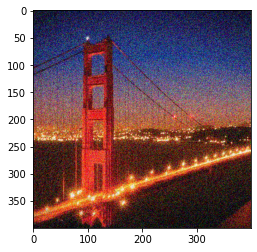

In [96]:
generated_image = tf.Variable(tf.image.convert_image_dtype(content_image, tf.float32))
noise = tf.random.uniform(tf.shape(generated_image), -0.25, 0.25)
generated_image = tf.add(generated_image, noise)
generated_image = tf.clip_by_value(generated_image, clip_value_min=0.0, clip_value_max=1.0)
generated_image = generated_image[:, :, :,:3]
imshow(generated_image.numpy()[0])
plt.show()
generated_image = tf.Variable(generated_image)

## load the pretrained model 

creates a function that takes vgg model and the intermidate layers to form another model

In [97]:
def get_layer_outputs(vgg, layer_names):
    
    """ Creates a vgg model that returns a list of intermediate output values."""
    outputs = [vgg.get_layer(layer[0]).output for layer in layer_names]
    
    model = tf.keras.Model([vgg.input], outputs)
    
    return model

create the model that takes the input as vgg.input and output as a list that contians imtermediate output values 

In [98]:
vgg_model_outputs = get_layer_outputs(vgg, style_layers+ content_layer)

we plug in content image and style image into the model, this will gives us the imtermediate output for both content_image and style_image 

In [99]:
content_target = vgg_model_outputs(content_image)  # Content encoder
style_targets = vgg_model_outputs(style_image)     # Style enconder

 Assign the content image to be the input of the VGG model.  
 
 Set a_C to be the hidden layer activation from the layer we have selected for the content image 

In [100]:
preprocessed_content =  tf.Variable(tf.image.convert_image_dtype(content_image, tf.float32))
a_C = vgg_model_outputs(preprocessed_content)

 Assign the input of the model to be the "style" image.
 
 Set a_S to be the hidden layer activation from the layer we have selected for the style image 

In [101]:
preprocessed_style =  tf.Variable(tf.image.convert_image_dtype(style_image, tf.float32))
a_S = vgg_model_outputs(preprocessed_style)

In [102]:
def clip_0_1(image):
    """
    Truncate all the pixels in the tensor to be between 0 and 1
    
    Arguments:
    image -- Tensor
    J_style -- style cost coded above

    Returns:
    Tensor
    """
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

def tensor_to_image(tensor):
    """
    Converts the given tensor into a PIL image
    
    Arguments:
    tensor -- Tensor
    
    Returns:
    Image: A PIL image
    """
    tensor = tensor * 255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor) > 3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return Image.fromarray(tensor)

train_step function defines the trainig step of the model. first we define an optimizer(in this case Adam), then apply gradient tape to record the forward propagation. then get the gradient. use optimizer to do update the weight. 

In [103]:

optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

@tf.function()
def train_step(generated_image):
    with tf.GradientTape() as tape:
        # In this function you must use the precomputed encoded images a_S and a_C
        # Compute a_G as the vgg_model_outputs for the current generated image
        
        a_G = vgg_model_outputs(generated_image)
        
        # Compute the style cost
        J_style = compute_style_cost(a_S,a_G)

        # Compute the content cost
        J_content = compute_content_cost(a_C,a_G)
        # Compute the total cost
        J = total_cost(J_content,J_style)
        
        
    grad = tape.gradient(J, generated_image)

    optimizer.apply_gradients([(grad, generated_image)])
    generated_image.assign(clip_0_1(generated_image))
    
    return J

processed to train the model 

2022-05-22 23:54:01.232089: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


completed 0.0 %


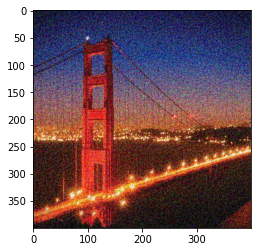

completed 10.0 %


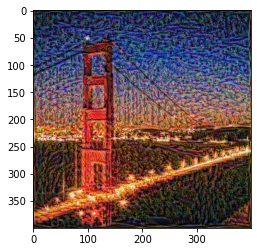

completed 20.0 %


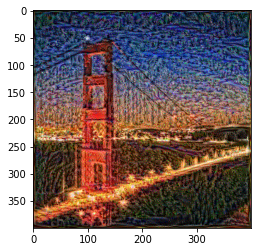

completed 30.0 %


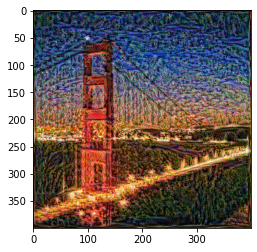

completed 40.0 %


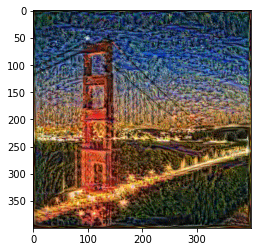

completed 50.0 %


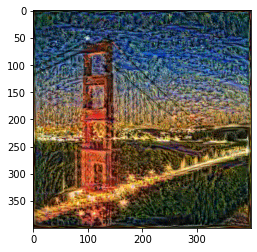

completed 60.0 %


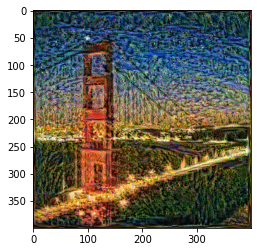

completed 70.0 %


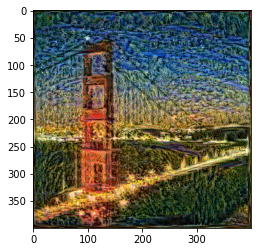

completed 80.0 %


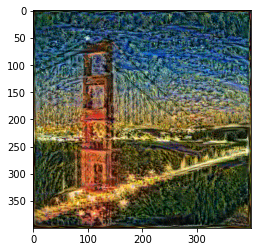

completed 90.0 %


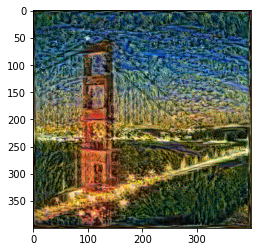

completed 100.0 %


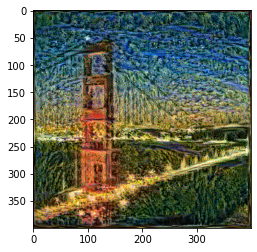

In [104]:
# Show the generated image at some epochs
# Uncoment to reset the style transfer process. You will need to compile the train_step function again 
epochs = 5001
for i in range(epochs):
    train_step(generated_image)
    if i % 500 == 0:
        print(f"completed {i/50} %")
    if i % 500 == 0:
        image = tensor_to_image(generated_image)
        imshow(image)
        image.save(f"output/image_{i}.jpg")
        plt.show() 